# 01 - NFL Data Exploration

**Goal**: Understand the NFL data structure and what we're working with

**My Thinking**: Before building any models, I need to understand:
- What data is available from nflreadpy
- Data quality and completeness
- Basic patterns in home field advantage, scoring trends
- How predictable are NFL games anyway?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nflreadpy as nfl
import pyarrow as pa
from statsmodels.stats.proportion import proportions_ztest
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("NFL Data Exploration with nflreadpy")
print(f"Current season: {nfl.get_current_season()}")
print(f"Current week: {nfl.get_current_week()}")

NFL Data Exploration with nflreadpy
Current season: 2025
Current week: 8


## Load and Inspect Data


In [ ]:
# Load game schedules and results for recent seasons
print("Loading NFL schedules and game results...")

seasons = [2020, 2021, 2022, 2023, 2024]
schedules = nfl.load_schedules(seasons)

games_df = schedules.to_pandas()

print(f"Loaded {len(games_df)} games from {min(seasons)}-{max(seasons)}")
print(f"Date range: {games_df['gameday'].min()} to {games_df['gameday'].max()}")
print(f"Columns available: {list(games_df.columns)}")

games_df.head()

Loading NFL schedules and game results...
Loaded 1408 games from 2020-2024
Date range: 2020-09-10 to 2025-02-09
Columns available: ['game_id', 'season', 'game_type', 'week', 'gameday', 'weekday', 'gametime', 'away_team', 'away_score', 'home_team', 'home_score', 'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis', 'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest', 'home_rest', 'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds', 'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game', 'roof', 'surface', 'temp', 'wind', 'away_qb_id', 'home_qb_id', 'away_qb_name', 'home_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium_id', 'stadium']


,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,2020_01_HOU_KC,2020,REG,1,2020-09-10,Thursday,20:20,HOU,20,KC,...,7.0,00-0033537,00-0033873,Deshaun Watson,Patrick Mahomes,Bill O'Brien,Andy Reid,Clete Blakeman,KAN00,Arrowhead Stadium
1,2020_01_SEA_ATL,2020,REG,1,2020-09-13,Sunday,13:00,SEA,38,ATL,...,NaN,00-0029263,00-0026143,Russell Wilson,Matt Ryan,Pete Carroll,Dan Quinn,Shawn Hochuli,ATL97,Mercedes-Benz Stadium
2,2020_01_CLE_BAL,2020,REG,1,2020-09-13,Sunday,13:00,CLE,6,BAL,...,5.0,00-0034855,00-0034796,Baker Mayfield,Lamar Jackson,Kevin Stefanski,John Harbaugh,Ronald Torbert,BAL00,M&T Bank Stadium
3,2020_01_NYJ_BUF,2020,REG,1,2020-09-13,Sunday,13:00,NYJ,17,BUF,...,15.0,00-0034869,00-0034857,Sam Darnold,Josh Allen,Adam Gase,Sean McDermott,Shawn Smith,BUF00,New Era Field
4,2020_01_LV_CAR,2020,REG,1,2020-09-13,Sunday,13:00,LV,34,CAR,...,5.0,00-0031280,00-0031237,Derek Carr,Teddy Bridgewater,Jon Gruden,Matt Rhule,Brad Allen,CAR00,Bank of America Stadium


## Data Quality Assessment

**My Hypothesis**: NFL data should be pretty clean, but I want to check if we need to map team migrations

Like when the rams moved, then we can make a src function to handle team migrations in the future


In [ ]:
# Data quality assessment
print("Data Quality Assessment")
print("=" * 40)

# Basic info
print(f"Dataset shape: {games_df.shape}")
print(f"Duplicate rows: {games_df.duplicated().sum()}")

# Check for missing values
print(f"\nMissing values by column:")
print(games_df.isnull().sum().sort_values(ascending=False))

# Check data types
print(f"\nData types:")
print(games_df.dtypes)

# Look at unique teams
print(f"\nUnique home teams: {games_df['home_team'].nunique()}")
print(f"Home teams: {sorted(games_df['home_team'].unique())}")

# Check for team name consistency
print(f"\nAway teams: {sorted(games_df['away_team'].unique())}")

Data Quality Assessment
Dataset shape: (1408, 46)
Duplicate rows: 0

Missing values by column:
nfl_detail_id       1136
pff                  854
wind                 594
temp                 594
ftn                  298
referee                1
gametime               0
away_team              0
game_id                0
season                 0
game_type              0
week                   0
gameday                0
weekday                0
total                  0
result                 0
location               0
home_score             0
home_team              0
away_score             0
gsis                   0
overtime               0
away_rest              0
home_rest              0
away_moneyline         0
home_moneyline         0
spread_line            0
old_game_id            0
pfr                    0
espn                   0
total_line             0
home_spread_odds       0
away_spread_odds       0
under_odds             0
roof                   0
div_game               0
surfa

## Basic NFL Patterns

**Questions I Want to Answer**:
1. How big is home field advantage really?
2. Are there any obvious trends over time?
3. Do we want to rank based on how teams play per quarter. Ie Rams played 3 bad quarters and one really good one, so maybe they kind of got lucky? Do we want to include a sort of metric like this


**Hypothesis Testing - Home Field Advantage during regular season, Statistical method ONE**


*Along with the questions above, here is the hypothesis testing

H0: The probability of the home team winning is equal to 50% (no home-field advantage)

Ha: The probability of the home team winning is greater than 50% (home-field advantage exists).

***Statistical test for result:***
The goal is to see how many games were won by the home team versus the away team to test whether or not there is a home-field advantage. We will use the Z-test because of the binary outcome (win or loss) and the sample size of data (around 272 games played in a regular season of the NFL)


We will be computing the z-test for each season and for all regular season games in the past five years in order to see the general effect and variability over time


Home Field Advantage Analysis
Home teams win 53.2% of games

Home win rate by season:
  2020: 49.6%
  2021: 51.5%
  2022: 55.7%
  2023: 55.5%
  2024: 53.3%

Average home field advantage: 1.7 points

 Total games and wins by season:
    season  season_home_wins  season_total_games
1    2021               140                 272
2    2022               151                 271
3    2023               151                 272
4    2024               145                 272

Season 2021: 'z_score': 0.4853, 'p_value': 0.3137
P-value is greater than alpha, fail to reject null hypothesis
There is not enough evidence to conclude that the average home win rate is greater than 50%.


Season 2022: 'z_score': 1.8956, 'p_value': 0.0290
P-value is less than alpha,reject null hypothesis
The average home win rate is significantly greater than 50%.


Season 2023: 'z_score': 1.8302, 'p_value': 0.0336
P-value is less than alpha,reject null hypothesis
The average home win rate is significantly greater than 

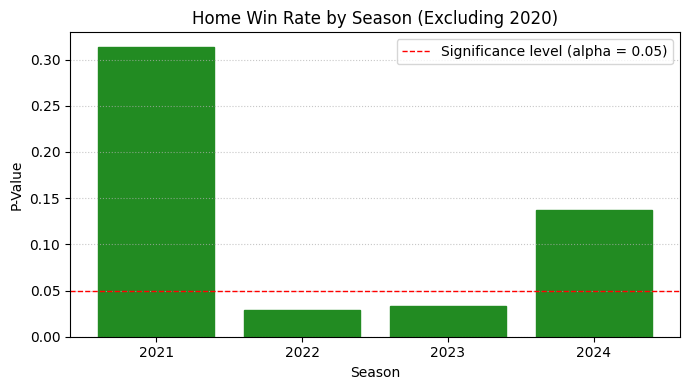

Z-Test for all regular season games in the completed_games dataset (excluding 2020):

Z-statistic: 2.6473
P-value: 0.0041
Conclusion: P-value less than alpha value, Reject the null hypothesis.

The average home win rate is significantly greater than 50%.


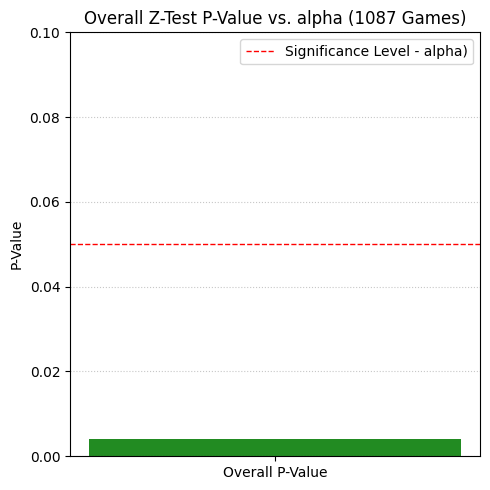

In [ ]:
print("Home Field Advantage Analysis")
print("=" * 40)

# Filter to reg szn only
completed_games = games_df[games_df['game_type'] == 'REG'].copy()
completed_games = completed_games[~completed_games['home_score'].isna()].copy()

if len(completed_games) > 0:
    # Calculate basic home field advantage
    completed_games['home_win'] = (completed_games['home_score'] > completed_games['away_score']).astype(int)

    home_win_rate = completed_games['home_win'].mean()
    print(f"Home teams win {home_win_rate:.1%} of games")

    # By season
    print(f"\nHome win rate by season:")
    season_home_wins = completed_games.groupby('season')['home_win'].mean()

    for season, win_rate in season_home_wins.items():
        print(f"  {season}: {win_rate:.1%}")


    # Calculate point differentials
    completed_games['point_diff'] = completed_games['home_score'] - completed_games['away_score']
    avg_home_advantage = completed_games['point_diff'].mean()
    print(f"\nAverage home field advantage: {avg_home_advantage:.1f} points")


    #Z-Test by Season
    # to keep track of data for table:
    season_res_chart = []
    #group by season with the total of home wins and total games for the season
    season_count = completed_games.groupby('season').agg(
        season_home_wins =('home_win', 'sum'),
        season_total_games = ('home_win', 'count')
    ).reset_index()
    #excluding 2020 season as a factor, COVID games had no fans
    season_count = season_count[season_count['season'] != 2020]
    print(f"\n Total games and wins by season:\n {season_count}")
    for row in season_count.itertuples():
      nobs=row[3]
      count=row[2]
      season=row[1]
      z_stat, p_value = proportions_ztest(count=count, nobs=nobs, value=0.5, alternative='larger')
      print(f"\nSeason {season}: 'z_score': {z_stat:.4f}, 'p_value': {p_value:.4f}")
      season_res_chart.append({'Season': str(season),
        'Observed Win Rate': count / nobs,
        'P-Value (one-sided)': p_value,
        'Home Wins': count,
        'Total Games': nobs})

      alpha = 0.05
      if p_value <= alpha:
        print("P-value is less than alpha,reject null hypothesis")
        print("The average home win rate is significantly greater than 50%.\n")
      else:
        print("P-value is greater than alpha, fail to reject null hypothesis")
        print("There is not enough evidence to conclude that the average home win rate is greater than 50%.\n")


    ##plot for first Z-test
    seasonal_df = pd.DataFrame(season_res_chart)
    plt.figure(figsize=(7, 4))
    bars = plt.bar(seasonal_df['Season'], seasonal_df['P-Value (one-sided)'])
    plt.axhline(0.05, color='red', linestyle='--', linewidth=1, label='Significance level (alpha = 0.05)')

    for bar in bars:
        bar.set_color('forestgreen')

    plt.title('Home Win Rate by Season (Excluding 2020)')
    plt.ylabel('P-Value')
    plt.xlabel('Season')
    plt.legend()
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()


    # Z-test Statistic for all regular season games:
    print("Z-Test for all regular season games in the completed_games dataset (excluding 2020):")
    updated_completed_games = completed_games[completed_games['season'] != 2020]
    total_home_wins= updated_completed_games['home_win'].sum().astype(int)
    n_games = updated_completed_games['home_win'].count().astype(int)
    z_stat, p_value = proportions_ztest(count=total_home_wins, nobs=n_games, value=0.5, alternative='larger')
    print(f"\nZ-statistic: {z_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    alpha = 0.05
    if p_value <= alpha:
      print("Conclusion: P-value less than alpha value, Reject the null hypothesis.")
      print("\nThe average home win rate is significantly greater than 50%.")
    else:
      print("Conclusion: P-value greater than alpha value, Fail to reject the null hypothesis.")
      print("\nThere is not enough evidence to conclude that the average home win rate is greater than 50%.")

    #Graph for second z-test for all season games (combined seasons)
    plt.figure(figsize=(5, 5))
    # Plot single bar to represent the p-value
    plt.bar(['Overall P-Value'], [p_value],
        color='forestgreen' ,
        width=0.5)

    #line for alpha
    plt.axhline(alpha, color='red', linestyle='--', linewidth=1, label=r'Significance Level - alpha)')

    plt.title(f'Overall Z-Test P-Value vs. alpha ({n_games} Games)')
    plt.ylabel('P-Value')
    plt.ylim(0, 0.1)
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No completed games found in dataset")

**Z-Test results/Conclusions**
1. Z-Test by Season

The 2021 and 2024 season both fail to reject the null hypothesis, and
the 2022 and 2023 season reject the null hypothesis.

The difference in these results suggest that home-field advantage may vary from year to year, because of its sensitivity to external factors (like COVID)

2. Z-Test, combining multiple seasons

Despite the fluctuations in the individual seasons, the combined data supports that nfl home teams won more than 50% of their games, indicating a robust overall home-field advantage.



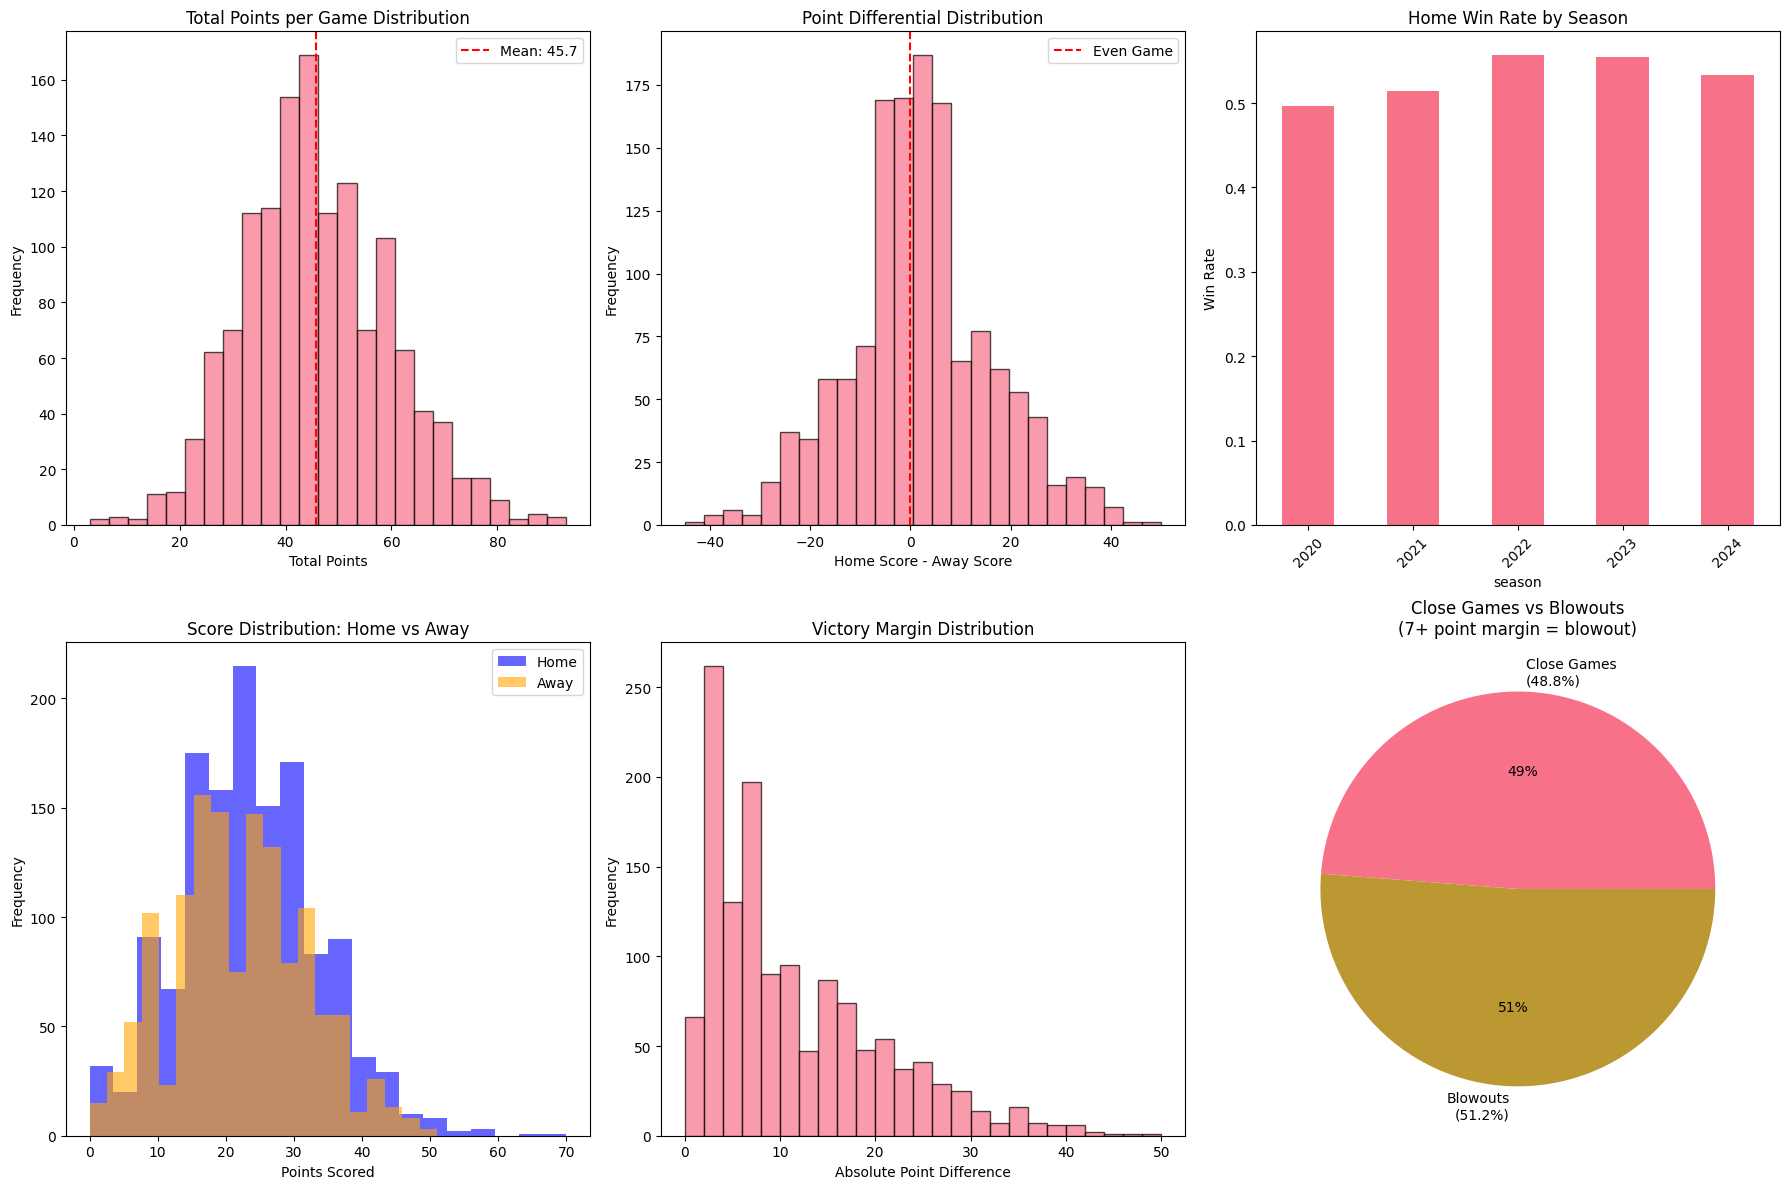


Summary Statistics:
Average total points: 45.7
Average victory margin: 11.1 points
Close games (≤7 pts): 48.8%
Highest scoring game: 93 points
Lowest scoring game: 3 points


In [ ]:
# Score distribution analysis and visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

if len(completed_games) > 0:
    # Total points per game
    completed_games['total_points'] = completed_games['home_score'] + completed_games['away_score']

    axes[0,0].hist(completed_games['total_points'], bins=25, alpha=0.7, edgecolor='black')
    axes[0,0].set_title('Total Points per Game Distribution')
    axes[0,0].set_xlabel('Total Points')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].axvline(completed_games['total_points'].mean(), color='red', linestyle='--',
                      label=f'Mean: {completed_games["total_points"].mean():.1f}')
    axes[0,0].legend()

    # Point spread distribution
    axes[0,1].hist(completed_games['point_diff'], bins=25, alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Point Differential Distribution')
    axes[0,1].set_xlabel('Home Score - Away Score')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].axvline(0, color='red', linestyle='--', label='Even Game')
    axes[0,1].legend()

    # Home win rate by season
    season_home_wins.plot(kind='bar', ax=axes[0,2])
    axes[0,2].set_title('Home Win Rate by Season')
    axes[0,2].set_ylabel('Win Rate')
    axes[0,2].tick_params(axis='x', rotation=45)

    # Home vs Away score distributions
    axes[1,0].hist(completed_games['home_score'], bins=20, alpha=0.6, label='Home', color='blue')
    axes[1,0].hist(completed_games['away_score'], bins=20, alpha=0.6, label='Away', color='orange')
    axes[1,0].set_title('Score Distribution: Home vs Away')
    axes[1,0].set_xlabel('Points Scored')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()

    # Blowout analysis
    completed_games['margin'] = completed_games['point_diff'].abs()
    axes[1,1].hist(completed_games['margin'], bins=25, alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Victory Margin Distribution')
    axes[1,1].set_xlabel('Absolute Point Difference')
    axes[1,1].set_ylabel('Frequency')

    # Close games analysis (within 7 points)
    close_games = completed_games[completed_games['margin'] <= 7]
    close_game_pct = len(close_games) / len(completed_games) * 100
    axes[1,2].pie([len(close_games), len(completed_games) - len(close_games)],
                  labels=[f'Close Games\n({close_game_pct:.1f}%)', f'Blowouts\n({100-close_game_pct:.1f}%)'],
                  autopct='%1.0f%%')
    axes[1,2].set_title('Close Games vs Blowouts\n(7+ point margin = blowout)')

plt.tight_layout()
plt.show()

if len(completed_games) > 0:
    print(f"\nSummary Statistics:")
    print(f"Average total points: {completed_games['total_points'].mean():.1f}")
    print(f"Average victory margin: {completed_games['margin'].mean():.1f} points")
    print(f"Close games (≤7 pts): {close_game_pct:.1f}%")
    print(f"Highest scoring game: {completed_games['total_points'].max()} points")
    print(f"Lowest scoring game: {completed_games['total_points'].min()} points")

**Statistical Methods (aside from the z-tests above)**

First, using descriptive statistics, we examined the score distributions for home and away teams. The data show that home teams tend to score more points on average than away teams, indicating a consistent home advantage effect. This indicates that whether a team is home or away is an important factor that influences overall team performance and game outcomes.

Next, we analyzed the distribution of score differentials. Games decided by seven points or fewer occurred 48.8% of the time, suggesting that nearly half of all games were competitive and well-balanced between teams. We can use this information to see which teams are pairing up well and to analyze patterns that might help predict future close games.




## Initial Insights

**What I'm Looking For**:
- Is home field advantage consistent across seasons?
- Are there any teams that consistently over/under-perform?
- How much do scores vary?
- Do we want to rank teams as high scorers bad defenders etc.

**My Expectations**:
- Home teams probably win ~55% of games
- Most games probably between 14-35 points per team
- Point spreads probably mostly within ±14 points

In [ ]:
# Team-level analysis
print("Team Performance Analysis")
print("=" * 40)

if len(completed_games) > 0:
    # Home performance by team
    home_stats = completed_games.groupby('home_team').agg({
        'home_win': 'mean',
        'home_score': 'mean',
        'away_score': 'mean',
        'point_diff': 'mean'
    }).round(3)
    home_stats.columns = ['home_win_rate', 'avg_home_score', 'avg_away_score_allowed', 'avg_home_margin']

    # Away performance by team
    away_stats = completed_games.groupby('away_team').agg({
        'home_win': lambda x: 1 - x.mean(),  # Away win rate
        'away_score': 'mean',
        'home_score': 'mean',
        'point_diff': lambda x: -x.mean()   # Flip sign for away perspective
    }).round(3)
    away_stats.columns = ['away_win_rate', 'avg_away_score', 'avg_home_score_allowed', 'avg_away_margin']

    print("Top 10 Home Teams (by win rate):")
    print(home_stats.sort_values('home_win_rate', ascending=False).head(10))

    print(f"\nTop 10 Away Teams (by win rate):")
    print(away_stats.sort_values('away_win_rate', ascending=False).head(10))

    # Overall team performance
    overall_wins = pd.DataFrame()

    # Home games
    home_games = completed_games.groupby('home_team').agg({
        'home_win': 'sum',
        'game_id': 'count'
    }).rename(columns={'home_win': 'home_wins', 'game_id': 'home_games'})

    # Away games
    away_games = completed_games.groupby('away_team').agg({
        'home_win': lambda x: (1-x).sum(),
        'game_id': 'count'
    }).rename(columns={'home_win': 'away_wins', 'game_id': 'away_games'})

    # Combine for overall record
    team_records = home_games.join(away_games, how='outer').fillna(0)
    team_records['total_wins'] = team_records['home_wins'] + team_records['away_wins']
    team_records['total_games'] = team_records['home_games'] + team_records['away_games']
    team_records['win_rate'] = team_records['total_wins'] / team_records['total_games']

    print(f"\nOverall Team Records (sorted by win rate):")
    print(team_records[['total_wins', 'total_games', 'win_rate']].sort_values('win_rate', ascending=False))

Team Performance Analysis
Top 10 Home Teams (by win rate):
           home_win_rate  avg_home_score  avg_away_score_allowed  \
home_team                                                          
BUF                0.833          30.405                  18.286   
KC                 0.786          25.024                  18.762   
GB                 0.738          26.405                  18.881   
MIA                0.690          25.214                  18.905   
DAL                0.643          29.976                  24.690   
PIT                0.643          21.738                  18.738   
PHI                0.643          26.476                  23.000   
BAL                0.643          27.524                  19.357   
MIN                0.619          25.619                  23.833   
CLE                0.619          20.833                  19.429   

           avg_home_margin  
home_team                   
BUF                 12.119  
KC                   6.262  
GB      

## Key Takeaways

**After running this analysis, I expect to learn**:
1. Whether the data is clean enough to use
2. Basic NFL patterns that will inform feature engineering
3. How variable outcomes are (affects model difficulty)
4. Any obvious biases or trends to account for

**Next Steps**:
- Move to feature engineering once I understand the data
- Focus on features that capture team strength and matchup dynamics

In [ ]:
# Explore team statistics for feature engineering insights
print("Team Statistics Analysis")
print("=" * 50)

# Load team statistics for offensive and defensive metrics
team_stats = nfl.load_team_stats(seasons)
team_stats_df = team_stats.to_pandas()

print(f"Team stats shape: {team_stats_df.shape}")
print(f"Available seasons: {sorted(team_stats_df['season'].unique())}")
print(f"Stat types: {sorted(team_stats_df.columns)}")

# Display sample team stats
sample_team_stats = team_stats_df[team_stats_df['season'] == 2023].head()
print(f"\nSample 2023 team stats:")
print(sample_team_stats)

Team Statistics Analysis
Team stats shape: (2816, 102)
Available seasons: [np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]
Stat types: ['attempts', 'carries', 'completions', 'def_fumbles', 'def_fumbles_forced', 'def_interception_yards', 'def_interceptions', 'def_pass_defended', 'def_qb_hits', 'def_sack_yards', 'def_sacks', 'def_safeties', 'def_tackle_assists', 'def_tackles_for_loss', 'def_tackles_for_loss_yards', 'def_tackles_solo', 'def_tackles_with_assist', 'def_tds', 'fg_att', 'fg_blocked', 'fg_blocked_distance', 'fg_blocked_list', 'fg_long', 'fg_made', 'fg_made_0_19', 'fg_made_20_29', 'fg_made_30_39', 'fg_made_40_49', 'fg_made_50_59', 'fg_made_60_', 'fg_made_distance', 'fg_made_list', 'fg_missed', 'fg_missed_0_19', 'fg_missed_20_29', 'fg_missed_30_39', 'fg_missed_40_49', 'fg_missed_50_59', 'fg_missed_60_', 'fg_missed_distance', 'fg_missed_list', 'fg_pct', 'fumble_recovery_opp', 'fumble_recovery_own', 'fumble_recovery_tds', 'fumble_recovery_yards_opp'

In [ ]:
# Explore play-by-play data for advanced metrics
print("Play-by-Play Data Analysis")
print("=" * 50)

# Load a sample of play-by-play data (recent season only to start)
pbp_2023 = nfl.load_pbp([2023])
pbp_df = pbp_2023.to_pandas()

print(f"PBP data shape: {pbp_df.shape}")
print(f"Date range: {pbp_df['game_date'].min()} to {pbp_df['game_date'].max()}")

# Key columns for prediction features
key_pbp_columns = ['game_id', 'home_team', 'away_team', 'posteam', 'defteam',
                   'yardline_100', 'down', 'ydstogo', 'yards_gained',
                   'rushing_yards', 'passing_yards', 'epa', 'wpa',
                   'home_score', 'away_score', 'game_seconds_remaining']

available_key_cols = [col for col in key_pbp_columns if col in pbp_df.columns]
print(f"\nKey columns available: {available_key_cols}")

# Look at EPA (Expected Points Added) distribution
if 'epa' in pbp_df.columns:
    print(f"\nEPA Statistics:")
    print(f"Mean EPA: {pbp_df['epa'].mean():.3f}")
    print(f"EPA std: {pbp_df['epa'].std():.3f}")
    print(f"EPA range: {pbp_df['epa'].min():.2f} to {pbp_df['epa'].max():.2f}")
else:
    print("EPA column not available")

Play-by-Play Data Analysis
PBP data shape: (49665, 372)
Date range: 2023-09-07 to 2024-02-11

Key columns available: ['game_id', 'home_team', 'away_team', 'posteam', 'defteam', 'yardline_100', 'down', 'ydstogo', 'yards_gained', 'rushing_yards', 'passing_yards', 'epa', 'wpa', 'home_score', 'away_score', 'game_seconds_remaining']

EPA Statistics:
Mean EPA: -0.027
EPA std: 1.261
EPA range: -12.44 to 8.88


In [ ]:
# Calculate team-level aggregated metrics for prediction features
print("Team Aggregated Metrics for ML Features")
print("=" * 50)

if 'epa' in pbp_df.columns and len(pbp_df) > 0:
    # Team offensive EPA per play
    team_off_epa = pbp_df.groupby(['game_id', 'posteam'])['epa'].mean().reset_index()
    team_off_epa.columns = ['game_id', 'team', 'off_epa_per_play']

    # Team defensive EPA per play (from opponent perspective)
    team_def_epa = pbp_df.groupby(['game_id', 'defteam'])['epa'].mean().reset_index()
    team_def_epa.columns = ['game_id', 'team', 'def_epa_allowed_per_play']
    team_def_epa['def_epa_allowed_per_play'] = -team_def_epa['def_epa_allowed_per_play']  # Flip sign for defense

    # Sample of aggregated metrics
    print("Sample offensive EPA by team-game:")
    print(team_off_epa.head(10))

    print("\nSample defensive EPA by team-game:")
    print(team_def_epa.head(10))

    # Season-level team averages
    season_off_epa = pbp_df.groupby(['season', 'posteam'])['epa'].mean().reset_index()
    season_off_epa.columns = ['season', 'team', 'season_off_epa']

    print(f"\n2023 Season Offensive EPA Leaders:")
    season_2023_off = season_off_epa[season_off_epa['season'] == 2023].sort_values('season_off_epa', ascending=False)
    print(season_2023_off.head(10))

else:
    print("EPA data not available for aggregation")

# Explore other potential features from schedules
print(f"\nPotential Prediction Features from Schedules:")
schedule_features = ['week', 'game_type', 'away_rest', 'home_rest', 'div_game']
available_schedule_features = [col for col in schedule_features if col in games_df.columns]
print(f"Available: {available_schedule_features}")

if 'div_game' in games_df.columns:
    div_game_rate = games_df['div_game'].mean() if games_df['div_game'].dtype == bool else None
    print(f"Division game percentage: {div_game_rate:.1%}" if div_game_rate else "Division game data format unclear")

Team Aggregated Metrics for ML Features
Sample offensive EPA by team-game:
           game_id team  off_epa_per_play
0  2023_01_ARI_WAS  ARI         -0.250087
1  2023_01_ARI_WAS  WAS         -0.199550
2  2023_01_BUF_NYJ  BUF         -0.113805
3  2023_01_BUF_NYJ  NYJ         -0.015500
4  2023_01_CAR_ATL  ATL         -0.064488
5  2023_01_CAR_ATL  CAR         -0.213298
6  2023_01_CIN_CLE  CIN         -0.410844
7  2023_01_CIN_CLE  CLE         -0.097276
8  2023_01_DAL_NYG  DAL          0.102061
9  2023_01_DAL_NYG  NYG         -0.501044

Sample defensive EPA by team-game:
           game_id team  def_epa_allowed_per_play
0  2023_01_ARI_WAS  ARI                  0.199550
1  2023_01_ARI_WAS  WAS                  0.250087
2  2023_01_BUF_NYJ  BUF                  0.015500
3  2023_01_BUF_NYJ  NYJ                  0.113805
4  2023_01_CAR_ATL  ATL                  0.213298
5  2023_01_CAR_ATL  CAR                  0.064488
6  2023_01_CIN_CLE  CIN                  0.097276
7  2023_01_CIN_CLE  CLE    

In [ ]:
# Explore additional data sources for enhanced predictions
print("Additional NFL Data Sources Exploration")
print("=" * 50)

# Player statistics for key position impact
try:
    player_stats = nfl.load_player_stats([2023])
    player_df = player_stats.to_pandas()
    print(f"Player stats loaded: {player_df.shape}")

    # Look at QB stats specifically (most predictive position)
    if 'position' in player_df.columns:
        qb_stats = player_df[player_df['position'] == 'QB']
        qb_key_stats = ['player_name', 'team', 'completions', 'attempts', 'passing_yards',
                       'passing_tds', 'interceptions', 'sacks', 'passing_epa']
        available_qb_stats = [col for col in qb_key_stats if col in qb_stats.columns]

        print(f"\nTop QBs by passing yards (2023):")
        if len(available_qb_stats) > 0:
            print(qb_stats[available_qb_stats].sort_values('passing_yards', ascending=False).head())

except Exception as e:
    print(f"Could not load player stats: {e}")

# Injury data - critical for predictions
try:
    injuries = nfl.load_injuries([2023])
    injury_df = injuries.to_pandas()
    print(f"\nInjury data loaded: {injury_df.shape}")

    if len(injury_df) > 0:
        print(f"Injury report columns: {list(injury_df.columns)}")

        # Sample of recent injury reports
        if 'report_status' in injury_df.columns:
            injury_status_counts = injury_df['report_status'].value_counts()
            print(f"\nInjury status breakdown:")
            print(injury_status_counts)

except Exception as e:
    print(f"Could not load injury data: {e}")

# Weather data impact (if available)
try:
    # Note: Weather might be in pbp or schedule data
    if 'weather' in games_df.columns:
        weather_games = games_df[~games_df['weather'].isna()]
        print(f"\nGames with weather data: {len(weather_games)}")
        print(f"Weather conditions: {weather_games['weather'].unique()[:10]}")
    elif 'temp' in games_df.columns:
        temp_games = games_df[~games_df['temp'].isna()]
        print(f"\nGames with temperature data: {len(temp_games)}")
        print(f"Temperature range: {temp_games['temp'].min():.1f}°F to {temp_games['temp'].max():.1f}°F")
    else:
        print("\nNo weather data found in schedule")

except Exception as e:
    print(f"Could not analyze weather data: {e}")


Additional NFL Data Sources Exploration
Player stats loaded: (18643, 114)

Top QBs by passing yards (2023):
        player_name team  completions  attempts  passing_yards  passing_tds  \
8903       C.Stroud  HOU           30        42            470            5   
570    T.Tagovailoa  MIA           28        45            466            3   
6265      P.Mahomes   KC           32        42            424            4   
14918     N.Mullens  MIN           22        36            411            2   
2676      J.Herbert  LAC           40        47            405            3   

       passing_epa  
8903     27.471965  
570      27.078331  
6265     22.319954  
14918     5.691321  
2676     21.501616  

Injury data loaded: (5599, 16)
Injury report columns: ['season', 'game_type', 'team', 'week', 'gsis_id', 'position', 'full_name', 'first_name', 'last_name', 'report_primary_injury', 'report_secondary_injury', 'report_status', 'practice_primary_injury', 'practice_secondary_injury', 'practic

## Key Features Identified for Moneyline Prediction

Based on the analysis above, here are the most promising features for predicting NFL moneyline winners:

### Core Team Performance Features (High Priority)
1. **EPA-based metrics** - Expected Points Added per play (offensive & defensive)
2. **Rolling win percentages** - Recent form over 4-8 game windows  
3. **Point differential trends** - Recent scoring margin performance
4. **Opponent-adjusted metrics** - Team performance vs strength of schedule

### Game Context Features (Medium Priority)
5. **Home field advantage** - Varies significantly by team
6. **Rest days** - Days between games impact performance
7. **Division games** - Familiarity factor in division matchups
8. **Game situation** - Week of season, playoff implications

### Advanced Features (Lower Priority, Data Permitting)
9. **Key player availability** - Starting QB, key offensive/defensive players
10. **Weather conditions** - Temperature, precipitation, wind for outdoor games
11. **Coaching adjustments** - Performance after bye weeks, coaching changes
12. **Recent trends** - Hot/cold streaks, momentum indicators

### Model Architecture Recommendations

**Target Variable**: Binary classification (1 = home team wins, 0 = away team wins)

**Temporal Validation**: Use time-series splits (train on past seasons, test on future)
- Example: Train 2020-2022, test on 2023, validate on 2024

**Feature Engineering Pattern**:
- Calculate rolling averages for key metrics (4-game and 8-game windows)
- Create matchup differentials (Team A offense vs Team B defense)
- Include opponent adjustments based on defensive/offensive rankings

**Success Metrics**:
- Raw accuracy (target: >55% to beat Vegas)
- Profitability when combined with betting odds
- Calibration of predicted probabilities

KeyError: 'team'

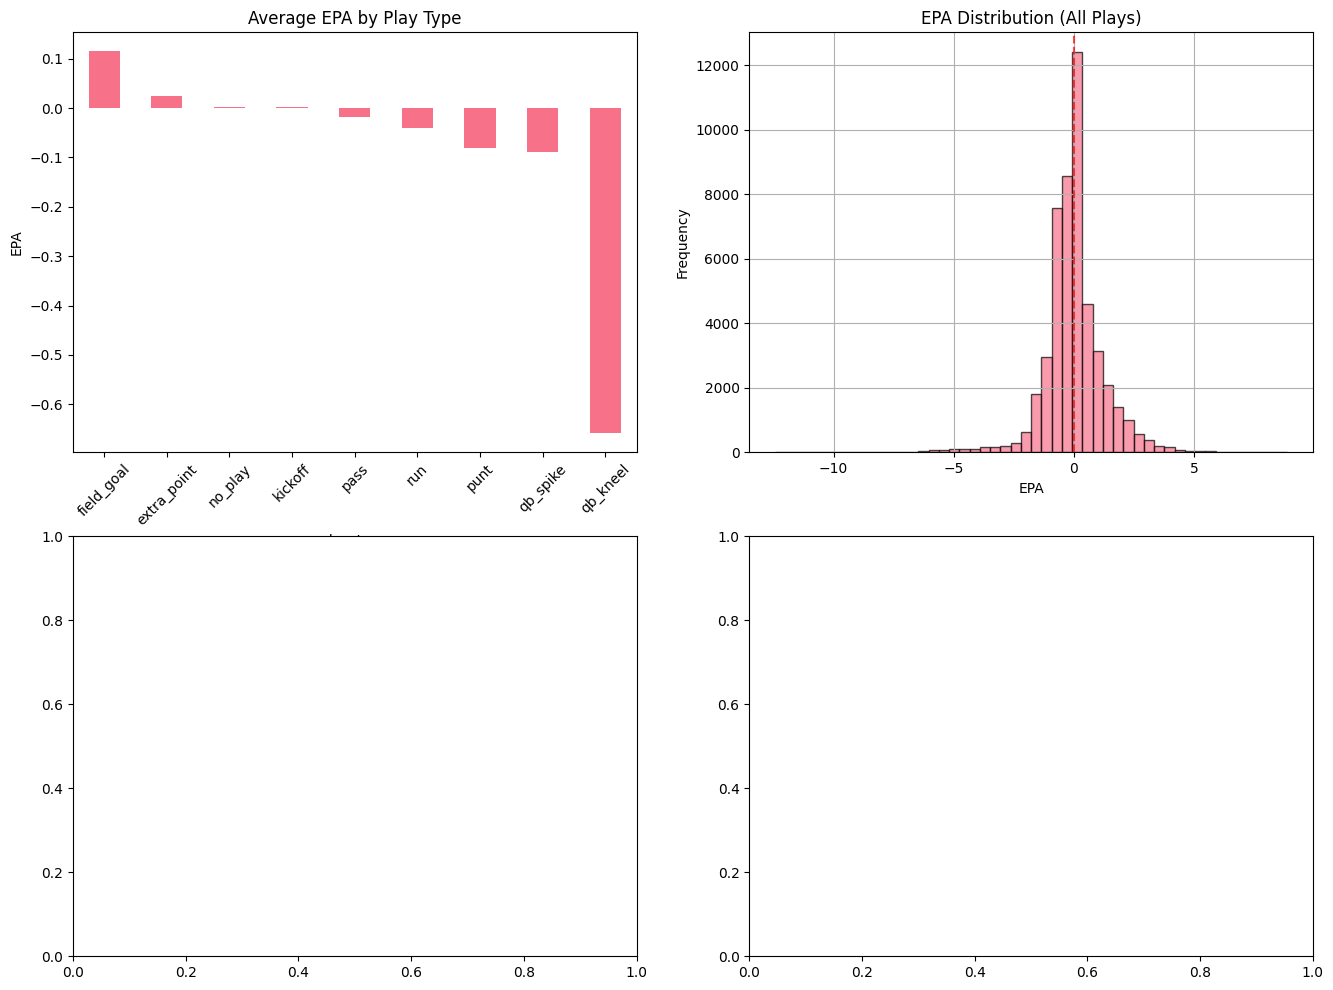

In [ ]:
# Advanced visualizations for EPA and team performance analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

if 'epa' in pbp_df.columns and len(pbp_df) > 0:
    # EPA distribution by play type
    if 'play_type' in pbp_df.columns:
        epa_by_play_type = pbp_df.groupby('play_type')['epa'].mean().sort_values(ascending=False)
        epa_by_play_type.plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Average EPA by Play Type')
        axes[0,0].set_ylabel('EPA')
        axes[0,0].tick_params(axis='x', rotation=45)

    # EPA distribution histogram
    pbp_df['epa'].hist(bins=50, ax=axes[0,1], alpha=0.7, edgecolor='black')
    axes[0,1].set_title('EPA Distribution (All Plays)')
    axes[0,1].set_xlabel('EPA')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].axvline(0, color='red', linestyle='--', alpha=0.7)

    # Team offensive EPA correlation with wins
    if len(season_off_epa) > 0 and len(team_records) > 0:
        # Merge EPA with win rates
        epa_wins = season_off_epa.merge(
            team_records.reset_index().rename(columns={'index': 'team'}),
            on='team', how='inner'
        )

        if len(epa_wins) > 0:
            axes[1,0].scatter(epa_wins['season_off_epa'], epa_wins['win_rate'], alpha=0.6)
            axes[1,0].set_xlabel('Season Offensive EPA per Play')
            axes[1,0].set_ylabel('Win Rate')
            axes[1,0].set_title('Offensive EPA vs Win Rate')

            # Add correlation coefficient
            correlation = epa_wins['season_off_epa'].corr(epa_wins['win_rate'])
            axes[1,0].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                          transform=axes[1,0].transAxes, verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Team performance visualization from schedule data
if len(completed_games) > 0:
    # Home field advantage by team
    hfa_by_team = completed_games.groupby('home_team').agg({
        'point_diff': 'mean',
        'game_id': 'count'
    }).rename(columns={'point_diff': 'avg_home_margin', 'game_id': 'home_games'})

    # Only teams with significant home games
    hfa_significant = hfa_by_team[hfa_by_team['home_games'] >= 20]

    if len(hfa_significant) > 0:
        hfa_significant['avg_home_margin'].sort_values(ascending=True).plot(kind='barh', ax=axes[1,1])
        axes[1,1].set_title('Home Field Advantage by Team\n(Average Point Differential)')
        axes[1,1].set_xlabel('Average Home Point Margin')
        axes[1,1].axvline(0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()